In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from copy import copy
import re
from sdg_clf.dataset_utils import preprocess_sample
try:
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
except:
    print('wordcloud not installed; pip install wordcloud')

sns.set()
sdg_colors = ['#E5243B', '#DDA63A', '#4C9F38','#C5192D','#FF3A21','#26BDE2','#FCC30B','#A21942','#FD6925','#DD1367','#FD9D24','#BF8B2E','#3F7E44','#0A97D9','#56C02B','#00689D','#19486A']

In [26]:
#Preprocessing
df = pd.read_csv('../data/raw/allSDGtweets.csv', encoding='latin1')

Earliest tweet:	2015-01-01 00:47:11,
 Last tweet:	2021-12-31 23:38:13


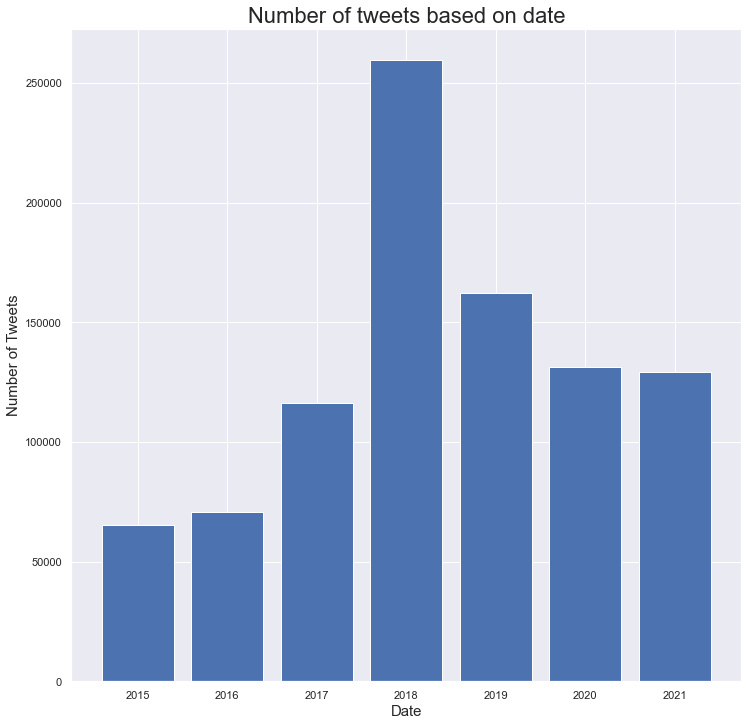

In [27]:
created_at = [datetime.strptime(df['created_at'][i], '%Y-%m-%dT%H:%M:%S.000Z') for i in range(len(df))]
print(f"Earliest tweet:\t{min(created_at)},\n Last tweet:\t{max(created_at)}")
created_at = [created_at[i].strftime('%Y') for i in range(len(created_at))]
x,y = np.unique(np.array(created_at), return_counts=True)
fig = plt.figure(figsize=(12,12))
plt.bar(x,y)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Number of Tweets',fontsize=15)
plt.title("Number of tweets based on date",fontsize=22)
plt.show()

In [28]:
df = df.drop(['Unnamed: 0', 'id','created_at','category'], axis=1)

In [29]:
df.head()

,text,lang,#sdg1,#sdg2,#sdg3,#sdg4,#sdg5,#sdg6,#sdg7,#sdg8,#sdg9,#sdg10,#sdg11,#sdg12,#sdg13,#sdg14,#sdg15,#sdg16,#sdg17,nclasses
0,"With 300 million people without #EnergyAccess,...",en,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,1
1,Happy new year 2019 to #Brussels #SDG11,en,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,1
2,Nearly 4 000 new followers joined us on social...,en,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,1
3,In 2019 Promoting @Najim_Ali five simple #Pas...,en,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,1
4,Please download the #Safecity Mobile app on An...,en,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1


In [30]:
# Non-processed DataFrame
print(len(df))
print(len(df['text'].unique()))

# DataFrame containing English tweets only
en_df = df[df['lang'] == 'en']
print(len(en_df))
print(len(en_df['text'].unique()))



935241
801856
784441
670768


The DataFrame contains a lot of duplicates, lets remove those.

In [31]:
df = df.drop_duplicates('text')
en_df = en_df.drop_duplicates('text')

In [32]:
print(len(df), len(en_df))

801856 670768


In [33]:
print(f"Scopus average number of characters per abstact {np.mean(en_df['text'].apply(len))}")
print(f"Scopus average number of characters per abstact {np.median(en_df['text'].apply(len))}")
print(f"Scopus minimum number of characters in an abstract {np.min(en_df['text'].apply(len))}")
print(f"Scopus maximum number of characters in an abstract {np.max(en_df['text'].apply(len))}")

Scopus average number of characters per abstact 191.037533096391
Scopus average number of characters per abstact 179.0
Scopus minimum number of characters in an abstract 4
Scopus maximum number of characters in an abstract 1871


In [34]:
print(f"Scopus average number of tokens per abstact {np.mean(en_df['text'].apply(lambda a: len(a.split(' '))))}")
print(f"Scopus average number of tokens per abstact {np.median(en_df['text'].apply(lambda a: len(a.split(' '))))}")
print(f"Scopus minimum number of tokens in an abstract {np.min(en_df['text'].apply(lambda a: len(a.split(' '))))}")
print(f"Scopus maximum number of tokens in an abstract {np.max(en_df['text'].apply(lambda a: len(a.split(' '))))}")

Scopus average number of tokens per abstact 23.982315793239987
Scopus average number of tokens per abstact 22.0
Scopus minimum number of tokens in an abstract 1
Scopus maximum number of tokens in an abstract 201


Since we will only be working with the English tweets, it is the DataFrame we will proceed with.

## Number of tweets with $n$ labels

In [35]:
print(f"Number of english tweets:\t {len(en_df)} \t({np.round(len(en_df)/len(df)*100,2)}%)")
for i in range(18):
    print(f"Number of nclasses = {i} tweets:\t {len(en_df[en_df['nclasses'] == i])} \t({np.round(len(en_df[en_df['nclasses'] == i])/len(en_df)*100,2)}%)")

Number of english tweets:	 670768 	(83.65%)
Number of nclasses = 0 tweets:	 225985 	(33.69%)
Number of nclasses = 1 tweets:	 398080 	(59.35%)
Number of nclasses = 2 tweets:	 35283 	(5.26%)
Number of nclasses = 3 tweets:	 7709 	(1.15%)
Number of nclasses = 4 tweets:	 2036 	(0.3%)
Number of nclasses = 5 tweets:	 901 	(0.13%)
Number of nclasses = 6 tweets:	 413 	(0.06%)
Number of nclasses = 7 tweets:	 203 	(0.03%)
Number of nclasses = 8 tweets:	 64 	(0.01%)
Number of nclasses = 9 tweets:	 32 	(0.0%)
Number of nclasses = 10 tweets:	 15 	(0.0%)
Number of nclasses = 11 tweets:	 13 	(0.0%)
Number of nclasses = 12 tweets:	 7 	(0.0%)
Number of nclasses = 13 tweets:	 1 	(0.0%)
Number of nclasses = 14 tweets:	 1 	(0.0%)
Number of nclasses = 15 tweets:	 0 	(0.0%)
Number of nclasses = 16 tweets:	 8 	(0.0%)
Number of nclasses = 17 tweets:	 17 	(0.0%)


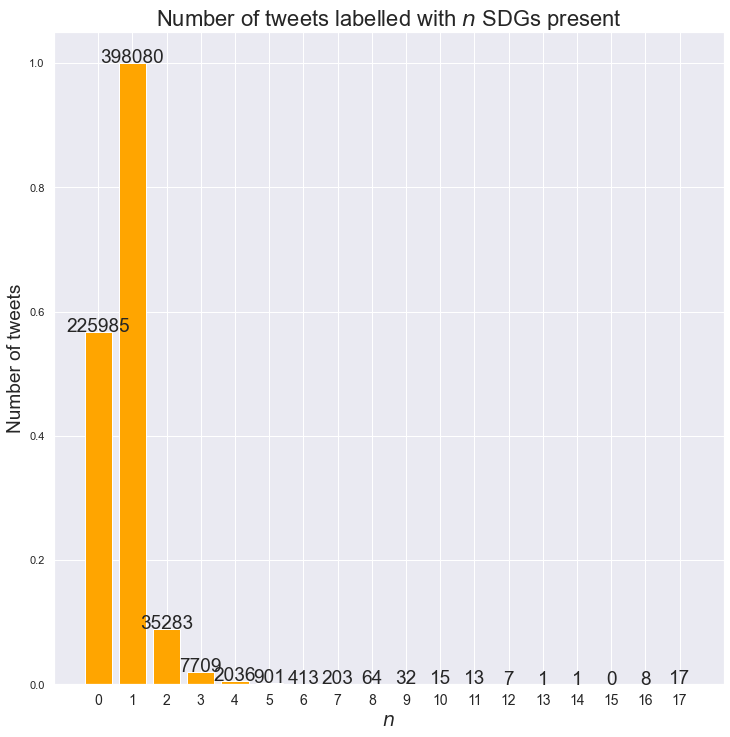

In [36]:
nclass = lambda i: len(en_df[en_df['nclasses'] == i])
fig = plt.figure(figsize=(12,12))
x = np.arange(18)
y = [nclass(i) for i in x]
norm_y = [(i - min(y)) / (max(y)-min(y)) for i in y]
# print(x,y)
plt.bar(x*2.5, norm_y, color='orange', width=2)
for xi, yi, text_y in zip(x, norm_y, y):
    plt.text(xi*2.5,yi,text_y,ha='center', fontsize=19)
plt.title("Number of tweets labelled with $n$ SDGs present",fontsize=22)
plt.xticks(x*2.5,x, fontsize=14)
plt.xlabel("$n$", fontsize=19)
plt.ylabel("Number of tweets", fontsize=19)
plt.show()

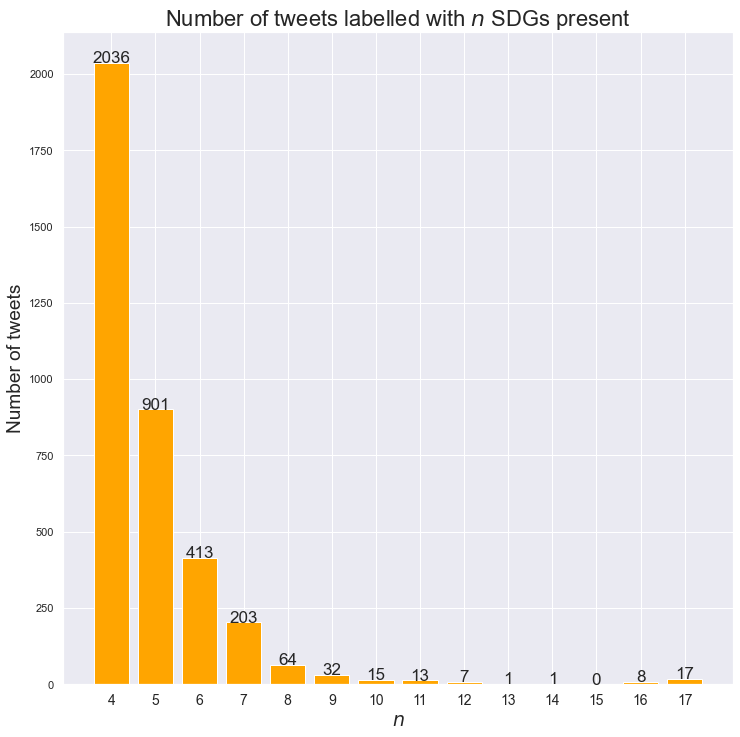

In [37]:
fig = plt.figure(figsize=(12,12))
x = range(4,18)
y = [len(en_df[en_df['nclasses'] == i]) for i in x]
# print(x,y)
plt.bar(x, y, color='orange')
for xi, yi in zip(x, y):
    plt.text(xi,yi,yi,ha='center', fontsize=17)
plt.title("Number of tweets labelled with $n$ SDGs present",fontsize=22)
plt.xticks(x,x, fontsize=14)
plt.xlabel("$n$", fontsize=19)
plt.ylabel("Number of tweets", fontsize=19)
plt.show()

## Tweet distribution

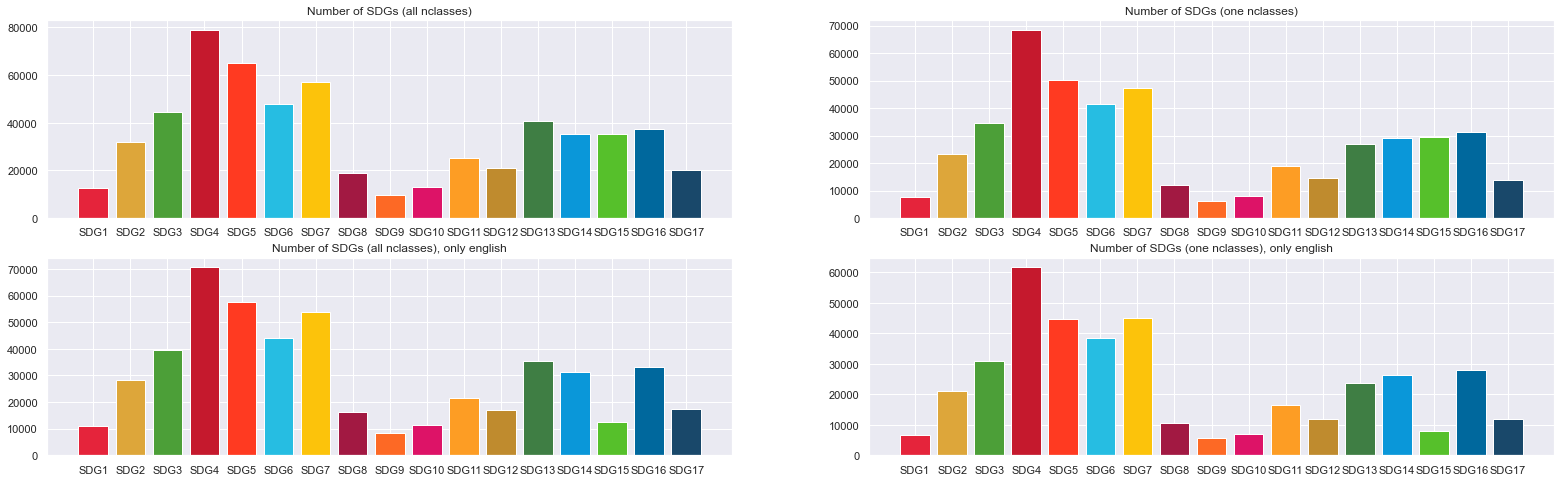

In [38]:
plt.figure(figsize=(27, 8))
plt.subplot(2,2,1)
plt.bar(range(1,18),[np.sum(df[f'#sdg{i}']) for i in range(1,18)], color=sdg_colors)
plt.xticks(range(1,18), [f'SDG{i}' for i in range(1,18)])
plt.title("Number of SDGs (all nclasses)")
plt.subplot(2,2,2)
plt.bar(range(1,18),[np.sum(df[df['nclasses'] == 1][f'#sdg{i}']) for i in range(1,18)], color=sdg_colors)
plt.xticks(range(1,18), [f'SDG{i}' for i in range(1,18)])
plt.title("Number of SDGs (one nclasses)")
plt.subplot(2,2,3)
plt.bar(range(1,18),[np.sum(en_df[f'#sdg{i}']) for i in range(1,18)], color=sdg_colors)
plt.xticks(range(1,18), [f'SDG{i}' for i in range(1,18)])
plt.title("Number of SDGs (all nclasses), only english")
plt.subplot(2,2,4)
plt.bar(range(1,18),[np.sum(en_df[en_df['nclasses'] == 1][f'#sdg{i}']) for i in range(1,18)], color=sdg_colors)
plt.xticks(range(1,18), [f'SDG{i}' for i in range(1,18)])
plt.title("Number of SDGs (one nclasses), only english")
plt.show()

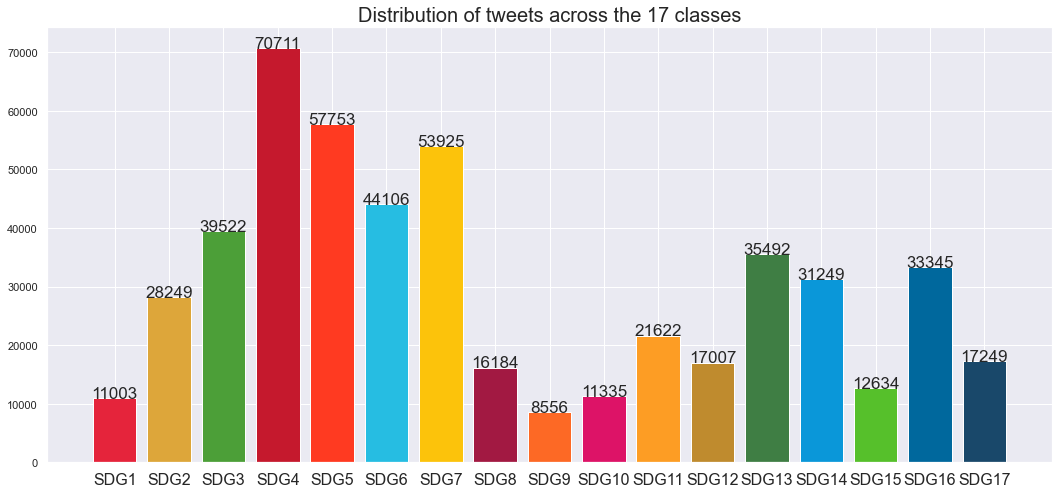

In [39]:
fig = plt.figure(figsize=(18,8))
x = range(1, 18)
y = [np.sum(en_df[f'#sdg{i}']) for i in range(1,18)]
plt.bar(x, y, color=sdg_colors)
for xi, yi in zip(x, y):
    plt.text(xi,yi,yi,ha='center', fontsize=17)
plt.title("Distribution of tweets across the 17 classes", fontsize=20)
plt.xticks(x, [f"SDG{i}" for i in x], fontsize=16)
plt.show()

### Co-occurence of SGDs

C:\Users\rasmu\AppData\Local\Temp\ipykernel_9320\1803285275.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(range(1,18), range(1,18), masked_data, cmap=palette)
C:\Users\rasmu\AppData\Local\Temp\ipykernel_9320\1803285275.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


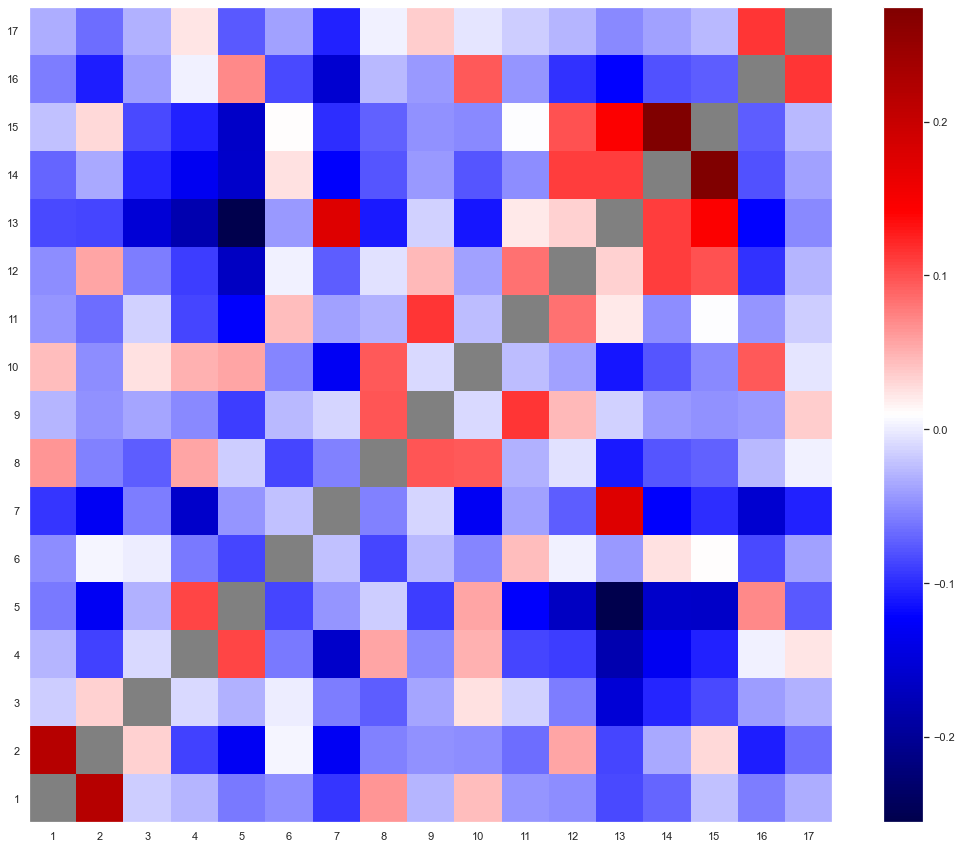

In [40]:
plt.figure(figsize=(18,15))
coocc = en_df[en_df['nclasses']>1][[f'#sdg{i}' for i in range(1,18)]].corr()
masked_data = np.ma.masked_array(coocc, np.identity(17))
palette = copy(plt.cm.seismic)
palette.set_bad('grey', 1.0)
plt.pcolormesh(range(1,18), range(1,18), masked_data, cmap=palette)
plt.xticks(range(1,18))
plt.yticks(range(1,18))
plt.colorbar()
plt.show()

## Tweet length

In [41]:
text_length = np.zeros(17)
word_text_length = np.zeros(17)

for i in range(1,18):
    for text in en_df[en_df[f'#sdg{i}'] == True]['text']:
        text_length[i-1] += len(text)
        word_text_length[i-1] += len(text.split())

text_length = text_length/([np.sum(en_df[f'#sdg{i}']) for i in range(1,18)])
word_text_length = word_text_length/([np.sum(en_df[f'#sdg{i}']) for i in range(1,18)])

for i in range(17):
    print(f"Average text length for #SDG{i+1}: {np.round(text_length[i])} characters per tweet \t {np.round(word_text_length[i])} words per tweet")

Average text length for #SDG1: 220.0 characters per tweet 	 28.0 words per tweet
Average text length for #SDG2: 229.0 characters per tweet 	 29.0 words per tweet
Average text length for #SDG3: 229.0 characters per tweet 	 29.0 words per tweet
Average text length for #SDG4: 223.0 characters per tweet 	 27.0 words per tweet
Average text length for #SDG5: 225.0 characters per tweet 	 28.0 words per tweet
Average text length for #SDG6: 217.0 characters per tweet 	 28.0 words per tweet
Average text length for #SDG7: 239.0 characters per tweet 	 29.0 words per tweet
Average text length for #SDG8: 231.0 characters per tweet 	 29.0 words per tweet
Average text length for #SDG9: 226.0 characters per tweet 	 27.0 words per tweet
Average text length for #SDG10: 228.0 characters per tweet 	 28.0 words per tweet
Average text length for #SDG11: 230.0 characters per tweet 	 28.0 words per tweet
Average text length for #SDG12: 230.0 characters per tweet 	 29.0 words per tweet
Average text length for #

## Vocabulary

In [42]:
df_sub = en_df.loc[:, 'text']
texts = " ".join([text.lower() for text in df_sub])
search_pattern = r"(<(u\+)\w+>)|((#sdg)(\d+)?)|((http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-]))|[\r\n]"
texts = re.sub(search_pattern, "", texts)

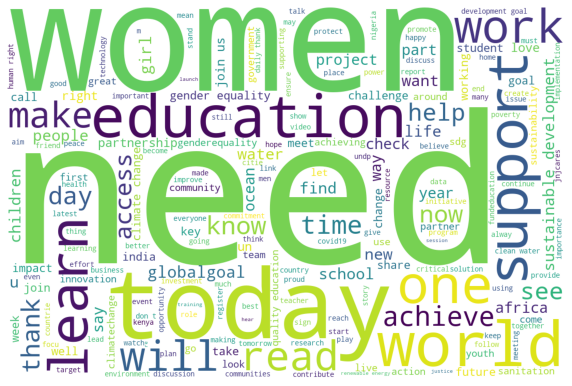

In [43]:
# Make a wordcloud for the English tweets and filter out certain words/character strings.

fig = plt.figure(figsize=(10,10))
stopwords = set(STOPWORDS)
stopwords.update(['s', 'amp'])
wordcloud = WordCloud(width=1080, height=720, stopwords=stopwords, background_color="white").generate(texts)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [44]:
word_dict = WordCloud(stopwords=stopwords).process_text(texts)
word_dict = {k: v for k, v in sorted(word_dict.items(), key=lambda item: item[1])}
list(word_dict.items())[-20:]

[('now', 11917),
 ('access', 11926),
 ('see', 11959),
 ('day', 12430),
 ('thank', 12993),
 ('know', 12994),
 ('time', 13545),
 ('achieve', 14566),
 ('make', 14758),
 ('read', 14924),
 ('will', 15027),
 ('work', 15152),
 ('one', 15390),
 ('learn', 15799),
 ('support', 17230),
 ('education', 18869),
 ('world', 21526),
 ('today', 23644),
 ('women', 23983),
 ('need', 24707)]

# Scopus

In [49]:
scopus_df = pd.read_csv("../data/raw/scopus_raw.csv")
# scopus_df = scopus_df.rename(columns={"Unnamed: 0": "idx"})
scopus_df = scopus_df.drop(columns=["Unnamed: 0"])
dropped_abstracts = []
scopus_df.head()

,Title,Year,Link,Abstract,Author.Keywords,Index.Keywords,EID,text,sdg1,sdg2,...,sdg9,sdg10,sdg11,sdg12,sdg13,sdg14,sdg15,sdg16,sdg17,nclasses
0,Counting the Costs: A Method for Evaluating th...,2020,https://www.scopus.com/inward/record.uri?eid=2...,"As we enter the decade of action on the SDGs, ...",agenda 2030; costing; goal 11; hard costs; inf...,NaN,2-s2.0-85107828156,Counting the Costs: A Method for Evaluating th...,False,False,...,False,False,True,False,False,False,False,False,False,1
1,Water research in support of the Sustainable D...,2020,https://www.scopus.com/inward/record.uri?eid=2...,Reaching the Sustainable Development Goal (SDG...,Belgium; Bibliometrics; Global South; North-So...,Climate change; Environmental protection; Plan...,2-s2.0-85090699582,Water research in support of the Sustainable D...,False,False,...,False,False,False,False,False,False,False,False,False,1
2,Global & geographical mapping and visualizatio...,2020,https://www.scopus.com/inward/record.uri?eid=2...,This paper presents a new knowledge base creat...,Actuation; AI; Big Data; Biographical Data; Cy...,Blood; Blood pressure; Health; Health risks; I...,2-s2.0-85099263145,Global & geographical mapping and visualizatio...,False,False,...,False,False,False,False,False,False,False,False,False,1
3,Learning from sustainability practice: case ex...,2020,https://www.scopus.com/inward/record.uri?eid=2...,Purpose: The purpose of this paper is to ident...,Hotels; Integrated social responsibility; Sust...,NaN,2-s2.0-85089153318,Learning from sustainability practice: case ex...,False,False,...,False,True,False,False,False,False,False,False,False,2
4,"Measuring What Matters, Where It Matters: A Sp...",2020,https://www.scopus.com/inward/record.uri?eid=2...,The Urban Environment and Social Inclusion Ind...,cities; equity; indices; new urban agenda; soc...,NaN,2-s2.0-85123219889,"Measuring What Matters, Where It Matters: A Sp...",False,False,...,False,False,True,False,False,False,False,False,False,1


Earliest tweet:	2015,
 Last tweet:	2022


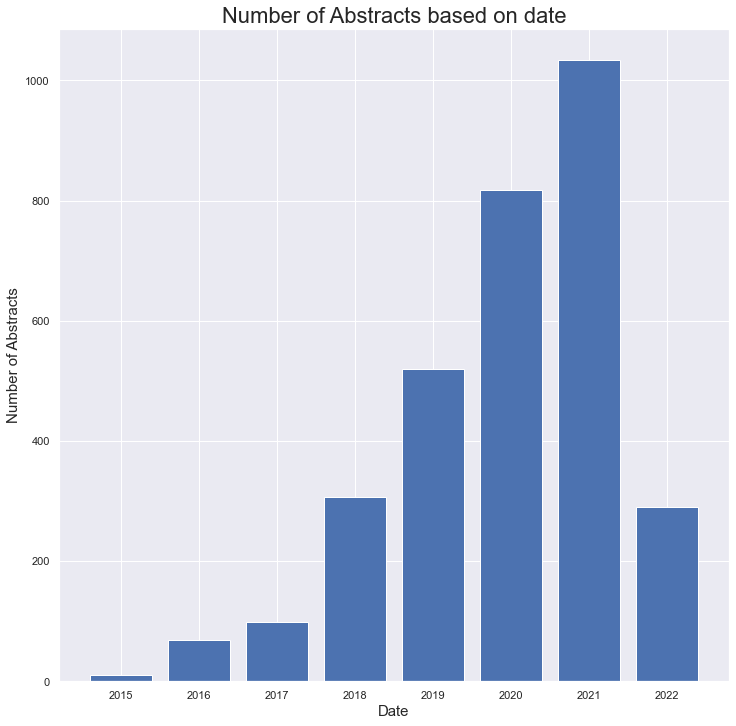

In [50]:
print(f"Earliest tweet:\t{min(scopus_df['Year'])},\n Last tweet:\t{max(scopus_df['Year'])}")
x,y = np.unique(np.array(scopus_df['Year']),return_counts=True)
fig = plt.figure(figsize=(12,12))
plt.bar(x,y)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Number of Abstracts',fontsize=15)
plt.title("Number of Abstracts based on date",fontsize=22)
plt.show()

## Fixing the dataset

In [51]:
reset_index = lambda df: df.reset_index(drop=True)
start_len = len(scopus_df)
print(start_len)

3142


In [52]:
scopus_df["Abstract"] = scopus_df["Abstract"].apply(lambda x: x.lower())

In [53]:
# Remove articles with no abstracts
print(f"{len(scopus_df[scopus_df['Abstract']=='[no abstract available]'])} ({np.round(len(scopus_df[scopus_df['Abstract']=='[no abstract available]'])/len(scopus_df)*100,2)}%) datapoints do not have an abstract")
no_abstract_idx = np.where(scopus_df['Abstract'].apply(len) == np.min(scopus_df['Abstract'].apply(len)))
scopus_df = scopus_df.drop(index = no_abstract_idx[0])
scopus_df = reset_index(scopus_df)
len(scopus_df)

47 (1.5%) datapoints do not have an abstract


3095

In [54]:
# Fix incorrectly labeled abstracts
pattern = re.compile(r"(sdg\s?1)(\D|$)")
for i, abstract in enumerate(scopus_df["Abstract"]):
    scopus_df.loc[i, "sdg1"] = True if pattern.search(abstract) is not None else False

In [55]:
# Remove shuidonggou (SDG) articles
shuidonggou_pattern = re.compile("shuidonggou")
for i, row in scopus_df.iterrows():
    if shuidonggou_pattern.search(row["Abstract"]) is not None:
        dropped_abstracts.append({"Abstract": row["Abstract"]})
        scopus_df.drop(i, axis=0, inplace=True)
scopus_df = reset_index(scopus_df)

In [56]:
# Remove rows without labels
for i, row in scopus_df.iterrows():
#     print(row)
    if row["nclasses"] == 0:
        dropped_abstracts.append({"Abstract": row["Abstract"]})
scopus_df = scopus_df[scopus_df["nclasses"] != 0]
scopus_df = reset_index(scopus_df)
len(scopus_df)

2812

In [57]:
# Re-calculate labels per abstract
for i, labels in enumerate(scopus_df.loc[:, "sdg1":"sdg17"].to_numpy()):
    scopus_df.loc[i, "nclasses"] = np.sum(labels)
end_len = len(scopus_df)
print(end_len)

2812


In [58]:
dropped_abstracts.append({"Abstract": "[no abstract available]"})

In [ ]:
for i in range(len(dropped_abstracts)):
    dropped_abstracts[i] = preprocess_sample(dropped_abstracts[i], tweet=False)

In [ ]:
import pickle
with open("dropped_abstracts.pkl", "wb") as f:
    pickle.dump(dropped_abstracts, f)

In [61]:
print(f"Number of articles removed {start_len - end_len}")
scopus_df.to_csv("../data/raw/scopus_ready_to_use.csv")

Number of articles removed 330


In [62]:
print(f"Scopus average number of characters per abstact {np.mean(scopus_df['Abstract'].apply(len))}")
print(f"Scopus minimum number of characters in an abstract {np.min(scopus_df['Abstract'].apply(len))}")
print(f"Scopus maximum number of characters in an abstract {np.max(scopus_df['Abstract'].apply(len))}")

Scopus average number of characters per abstact 1696.9790184921765
Scopus minimum number of characters in an abstract 256
Scopus maximum number of characters in an abstract 10237


In [63]:
print(f"Scopus average number of tokens per abstact {np.mean(scopus_df['Abstract'].apply(lambda a: len(a.split(' '))))}")
print(f"Scopus minimum number of tokens in an abstract {np.min(scopus_df['Abstract'].apply(lambda a: len(a.split(' '))))}")
print(f"Scopus maximum number of tokens in an abstract {np.max(scopus_df['Abstract'].apply(lambda a: len(a.split(' '))))}")

Scopus average number of tokens per abstact 244.56401137980086
Scopus minimum number of tokens in an abstract 36
Scopus maximum number of tokens in an abstract 1557


## SDG distribution

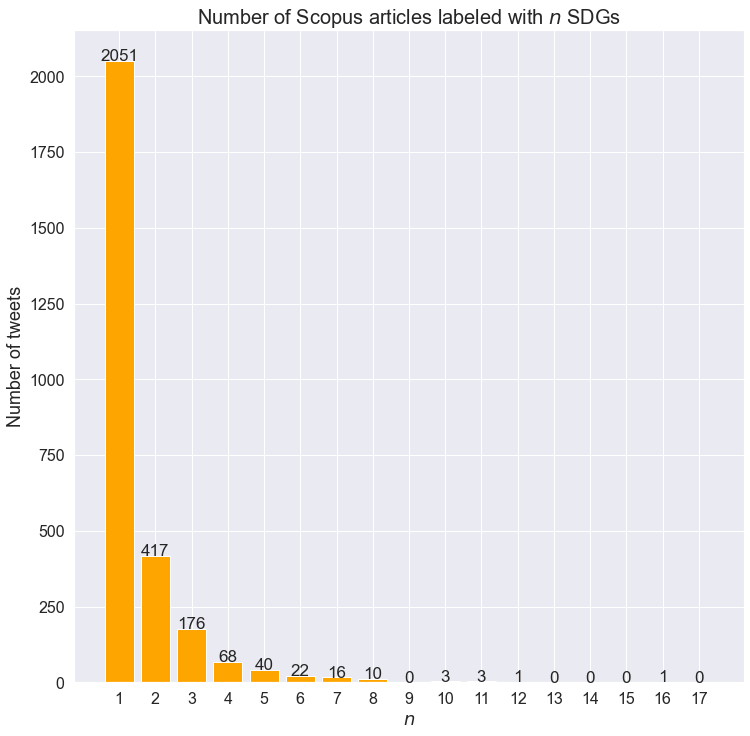

In [64]:
fig = plt.figure(figsize=(12,12))
x = range(1,18)
y = [len(scopus_df[scopus_df['nclasses'] == i]) for i in x]
# print(x,y)
plt.bar(x, y, color='orange')
for xi, yi in zip(x, y):
    plt.text(xi,yi,yi,ha='center', fontsize=17)
plt.title("Number of Scopus articles labeled with $n$ SDGs", fontsize=20)
plt.xticks(x,x, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$n$", fontsize=18)
plt.ylabel("Number of tweets",fontsize=18)
plt.show()

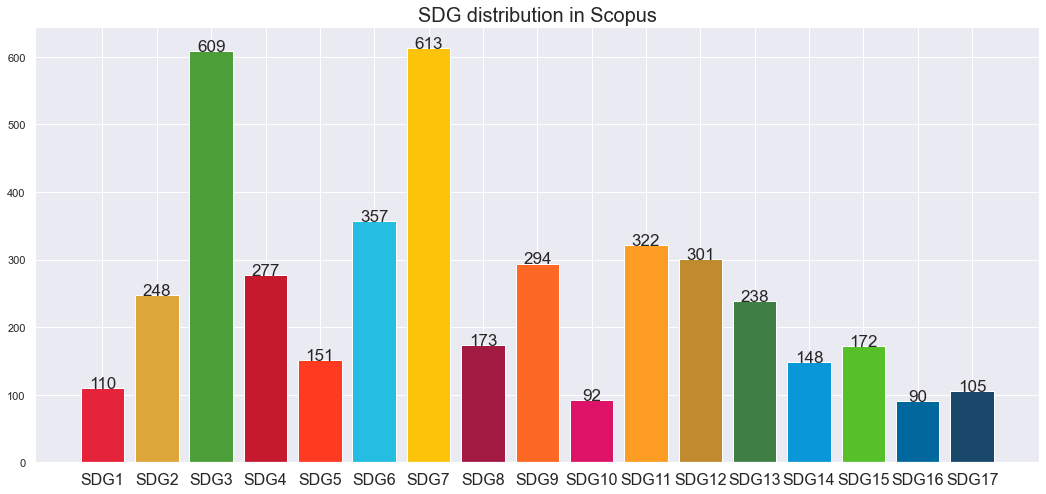

In [65]:
fig = plt.figure(figsize=(18,8))
x = range(1, 18)
y = [scopus_df[f"sdg{i}"].sum() for i in x]
plt.bar(x, y, color=sdg_colors)
for xi, yi in zip(x, y):
    plt.text(xi,yi,yi,ha='center', fontsize=17)
plt.title("SDG distribution in Scopus", fontsize=20)
plt.xticks(x, [f"SDG{i}" for i in x], fontsize=16)
plt.show()

## Co-occurrence matrix

C:\Users\rasmu\AppData\Local\Temp\ipykernel_9320\267149180.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(range(1,18), range(1,18), masked_data, cmap=palette)
C:\Users\rasmu\AppData\Local\Temp\ipykernel_9320\267149180.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


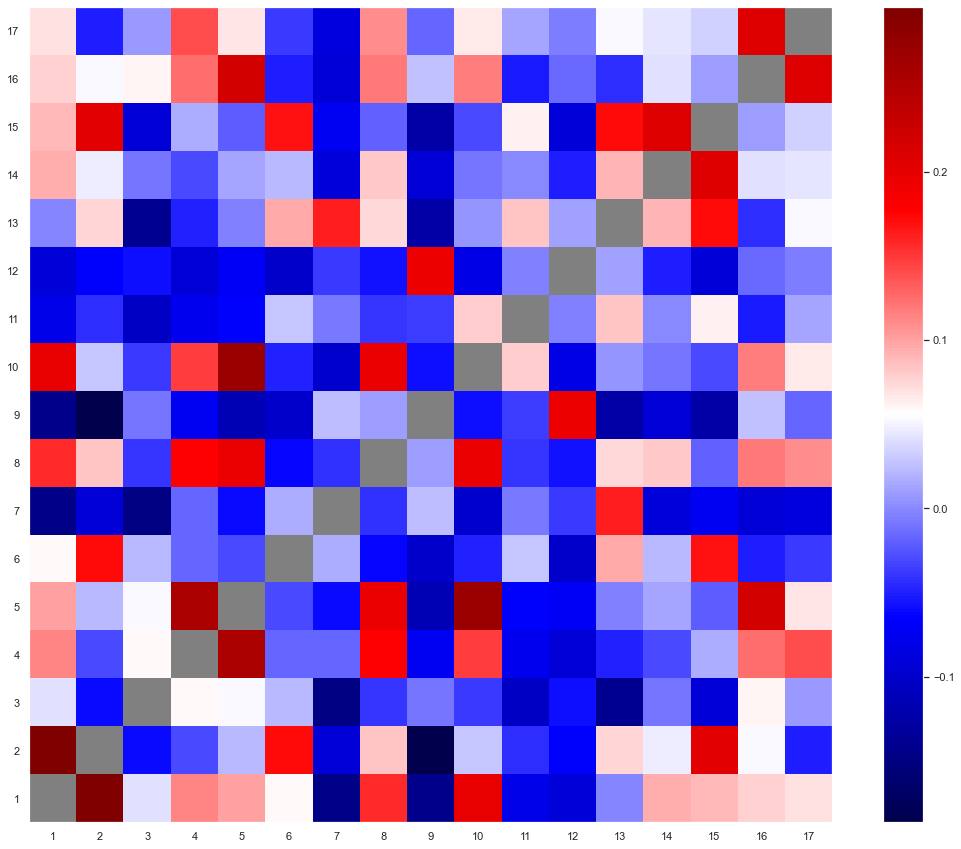

In [66]:
plt.figure(figsize=(18,15))
coocc = scopus_df[scopus_df['nclasses']>1][[f'sdg{i}' for i in range(1,18)]].corr()
masked_data = np.ma.masked_array(coocc, np.identity(17))
palette = copy(plt.cm.seismic)
palette.set_bad('grey', 1.0)
plt.pcolormesh(range(1,18), range(1,18), masked_data, cmap=palette)
plt.xticks(range(1,18))
plt.yticks(range(1,18))
plt.colorbar()
plt.show()

In [67]:
try:
    import textstat
    FLES_scopus = []
    FLES_tweets = []

    for text in scopus_df['Abstract']:
        FLES_scopus.append(textstat.flesch_reading_ease(text))
    for text in en_df['text']:
        FLES_tweets.append(textstat.flesch_reading_ease(text))

    print(f'Flesch Reading Ease:  \t twitter: {np.mean(FLES_tweets)},\t scopus: {np.mean(FLES_scopus)}')
except:
    print("textstat not installed")

textstat not installed


## WordCloud

In [68]:
scopus_texts = " ".join([text.lower() for text in scopus_df.loc[:, 'Abstract']])
search_pattern = r"(<(u\+)\w+>)|((#sdg)(\d+)?)|((http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-]))|[\r\n]"
scopus_texts = re.sub(search_pattern, "", scopus_texts)

In [69]:
stopwords = set(STOPWORDS)
stopwords.update(['s', 'amp', "sustainable development", "sustainability", "sdg", "sdgs", "development goal", "sustainable development goal", "sustainable", "development", "goal", "goals", "elsevier", "inc"])
word_dict_ = WordCloud(stopwords=stopwords).process_text(scopus_texts)
word_dict_ = {k: v for k, v in sorted(word_dict_.items(), key=lambda item: item[1])}
list(word_dict_.items())[-20:]

[('global', 707),
 ('potential', 707),
 ('data', 714),
 ('provide', 756),
 ('used', 763),
 ('need', 769),
 ('method', 789),
 ('challenge', 805),
 ('use', 812),
 ('author', 819),
 ('water', 831),
 ('well', 839),
 ('result', 848),
 ('using', 924),
 ('system', 934),
 ('research', 944),
 ('indicator', 965),
 ('target', 974),
 ('study', 1124),
 ('based', 1239)]

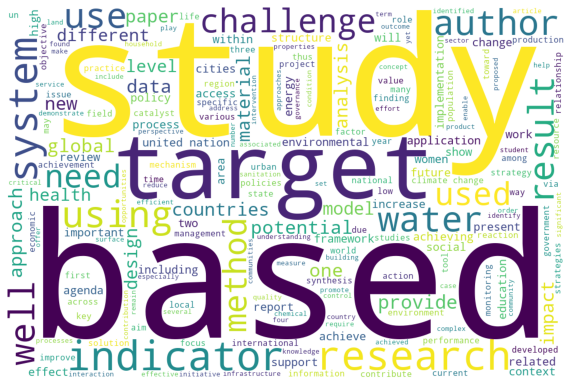

In [70]:
# Make a wordcloud for the English tweets and filter out certain words/character strings.

fig = plt.figure(figsize=(10,10))
stopwords = set(STOPWORDS)
stopwords.update(['s', 'amp', "sustainable development", "sustainability", "sdg", "sdgs", "development goal", "sustainable development goal", "sustainable", "development", "goal", "goals", "elsevier", "inc"])
wordcloud = WordCloud(width=1080, height=720, stopwords=stopwords, background_color="white").generate(scopus_texts)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [81]:
n_tweet = len(en_df[en_df["nclasses"] == 1])
n_scopus = len(scopus_df[scopus_df["nclasses"] == 1])

In [98]:
twitter_percentiles = np.cumsum([en_df[f"#sdg{i}"].sum() / en_df.loc[:, "#sdg1":"#sdg17"].sum().sum() for i in range(1, 18)])
scopus_percentiles = np.cumsum([scopus_df[f"sdg{i}"].sum() / scopus_df.loc[:, "sdg1":"sdg17"].sum().sum() for i in range(1, 18)])

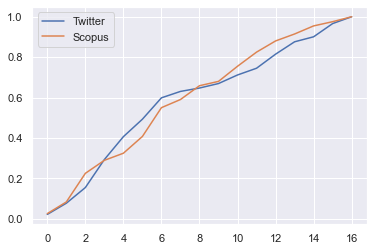

In [100]:
plt.plot(range(17), twitter_percentiles, label="Twitter")
plt.plot(range(17), scopus_percentiles, label="Scopus")
plt.legend()
plt.show()

In [104]:
n = len(scopus_df[scopus_df["nclasses"] != 0])

In [105]:
m = len(en_df[en_df["nclasses"] != 0])

In [106]:
test_statistic = np.max(np.abs(scopus_percentiles-twitter_percentiles))

In [108]:
c = lambda alpha: np.sqrt(-np.log(alpha/2)*0.5)
test_statistic

0.08544556594808361

In [111]:
c(0.05) * np.sqrt((n + m)/(n*m))

0.025709892749438565